# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

In [1]:
%pip install -qU \
    qdrant-client \
    langchain_openai \
    langchain_huggingface \
    langchain_core===0.2.39 \
    langchain \
    langchain_community \
    langchain-text-splitters \
    langchain-cohere \
    rank_bm25 \
    ragas \
    langchain-qdrant \
    langchain_experimental 

Note: you may need to restart the kernel to use updated packages.


We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [2]:
# %pip uninstall  \
#     qdrant-client \
#     ragas==0.1.18  \
#     langsmith \
#     langchain-core \
#     langchain-community \
#     langchain-openai \
#     langchain-qdrant \
#     langchain_experimental  \
#     langchain-cohere \
#     rank_bm25 -y

We'll also provide our OpenAI key, as well as our Cohere API key.

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [83]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [5]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

--2024-10-02 20:16:19--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19628 (19K) [text/plain]
Saving to: ‘john_wick_1.csv’

john_wick_1.csv     100%[===================>]  19.17K  --.-KB/s    in 0.001s  

2024-10-02 20:16:19 (29.6 MB/s) - ‘john_wick_1.csv’ saved [19628/19628]

--2024-10-02 20:16:19--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [6]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta
from langchain_core.documents import Document

documents : list[Document] = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

Let's look at an example document to see if everything worked as expected!

In [7]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2024, 9, 29, 20, 16, 21, 775305)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [8]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [9]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [10]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-3.5-turbo` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [11]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI()

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [12]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [13]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the reviews provided.'

In [14]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'No, there are no reviews with a rating of 10 for "John Wick 4."'

In [15]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, an ex-hit-man comes out of retirement to seek vengeance against the gangsters who killed his dog and took everything from him. This leads to a series of violent confrontations and thrilling action sequences.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [16]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [17]:
naive_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [18]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Opinions on John Wick seem to vary. Some people really enjoyed the action and style of the movie, while others found it lacking in substance or too violent. So, it's safe to say that not everyone liked John Wick."

In [19]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"I'm sorry, there are no reviews with a rating of 10 in the context provided."

In [20]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'John Wick is an action movie series that follows the story of a retired hitman, John Wick, who seeks vengeance after the death of his dog, which was a final gift from his late wife. The series is known for its intense action scenes, choreography, and emotional depth.'

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [89]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [90]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [23]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the positive reviews provided in the context.'

In [24]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Yes, there is a review with a rating of 10. Here is the URL to that review: '/review/rw4854296/?ref_=tt_urv'"

In [25]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick 2, after resolving his issues with the Russian mafia, John Wick returns home only to be visited by mobster Santino D'Antonio who asks for his help. When John refuses, Santino blows up his house. John Wick then meets with Winston, the owner of the Continental hotel, who tells him he cannot violate Mafia rules and must honor the marker. Santino asks John Wick to kill his sister in Rome. After completing the assignment, Santino puts a seven-million dollar contract on John Wick, leading to a showdown between them."

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [26]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [27]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [28]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, it seems that people generally liked John Wick. The movie received positive feedback for its action sequences, Keanu Reeves' performance, and overall entertainment value."

In [29]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'I\'m sorry, but there are no reviews with a rating of 10 for the movie "John Wick 4."'

In [30]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick: Chapter 2, the plot revolves around John Wick being forced back into the world of assassins when an Italian crime lord calls in a favor, leading Wick to carry out a dangerous mission in Rome. Wick faces numerous professional killers and ultimately seeks revenge against those who have betrayed him.'

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [31]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [32]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

/var/folders/fy/bc970z1n26gflr1xr_4kr5380000gn/T/ipykernel_44772/3574430551.py:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the langchain-qdrant package and should be used instead. To use it run `pip install -U langchain-qdrant` and import as `from langchain_qdrant import Qdrant`.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [33]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [34]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [35]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [36]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"People's opinions on John Wick seem to vary. Some love the series and consider it a wild ride, while others find it to be horrible and nonsensical. It ultimately depends on personal taste."

In [37]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review: \'/review/rw4854296/?ref_=tt_urv\' for the movie "John Wick 3".'

In [38]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, Keanu Reeves plays the character of John Wick, a retired assassin who comes out of retirement after someone kills his dog and steals his car. He is forced back into the world of assassins and has to travel to Italy, Canada, and Manhattan to take on numerous adversaries, including other assassins. The movie is known for its intense action and high body count.'

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [93]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [94]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [41]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, it seems that people generally liked John Wick. The majority of reviews praised the movie for its action sequences, Keanu Reeves' performance, and the overall entertainment value. Additionally, many reviewers recommended the film to action fans and highlighted its unique and stylish approach to the genre."

In [42]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for the movie "John Wick 3." Here is the URL to that review: \'/review/rw4854296/?ref_=tt_urv\''

In [43]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In "John Wick," an ex-hitman comes out of retirement to seek vengeance against the gangsters who killed his dog and took everything from him. The movie features plenty of action, shootouts, and breathtaking fights as John Wick unleashes a maelstrom of destruction against those who come after him. Ultimately, the plot revolves around John Wick\'s quest for revenge and the consequences of his actions.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

In [44]:
# !pip install -qU langchain_experimental

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [45]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [46]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [47]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [48]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [49]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [50]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, it seems that John Wick was generally liked by people.'

In [51]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for the movie "John Wick 3". Here is the URL to that review: \'/review/rw4854296/?ref_=tt_urv\''

In [52]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, the main character seeks revenge on the people who took something he loved from him. Specifically, his dog was killed, and his car was stolen, leading to a lot of carnage as he goes after those responsible.'

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

## LangSmith Setup

In [53]:
import os
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"

os.environ["LANGCHAIN_PROJECT"] = f"AIE4 - Advanced Retrieval Evaluation - {uuid4()}"

os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

## Utility Functions

In [54]:
import time
from datasets import Dataset
from ragas.metrics import context_precision, context_recall
from ragas import evaluate
import pandas as pd
import os
import pickle
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from pydantic import BaseModel

# Function to create a synthetic dataset using specified LLMs and criteria
async def create_synthetic_dataset(documents, num_questions=40, output_path='dataset.pkl'):
    generator_llm = ChatOpenAI(model="gpt-4o")
    critic_llm = ChatOpenAI(model="gpt-4o")
    embeddings = OpenAIEmbeddings()

    generator = TestsetGenerator.from_langchain(generator_llm, critic_llm, embeddings)
    distributions = {simple: 0.5, multi_context: 0.4, reasoning: 0.1}
    
    # Generating synthetic dataset
    synthetic_dataset = generator.generate_with_langchain_docs(
        documents, num_questions, distributions, with_debugging_logs=False
    )
    synthetic_dataset.to_pandas().to_csv("synthetic_dataset.csv", index=False)
    
    # Save dataset for future use
    with open(output_path, 'wb') as f:
        pickle.dump(synthetic_dataset, f)
    
    print(f"Synthetic dataset created and saved at {output_path}")
    return synthetic_dataset

# Function to load the dataset if already saved
def load_synthetic_dataset(input_path='dataset.pkl'):
    if os.path.exists(input_path):
        with open(input_path, 'rb') as f:
            dataset = pickle.load(f)
        print(f"Loaded dataset from {input_path}")
        return dataset
    else:
        print(f"No dataset found at {input_path}, please create one.")
        return None


# Generalized function to evaluate any retriever chain on the dataset
def evaluate_retriever_chain(retriever_chain, questions, ground_truths):
    responses = []
    latencies = []
    tokens_used = []
    
    for question in questions:
        start = time.time()
        result = retriever_chain.invoke({"question": question})
        latency = time.time() - start
        
        responses.append(result["response"].content)
        tokens_used.append(result["response"].response_metadata["token_usage"]["total_tokens"])
        latencies.append(latency)
    
    # Return as a dataset for further processing
    return Dataset.from_dict({
        "questions": questions,
        "answers": responses,
        "ground_truths": ground_truths,
        "latency": latencies,
        "tokens_used": tokens_used
    })


# Function to evaluate the dataset using context precision and recall metrics
def compute_metrics(dataset):
    metrics_result = evaluate(
        dataset, metrics=[context_precision, context_recall]
    )
    return metrics_result


# Function to merge the evaluated metrics with the response data and save to a file
def merge_and_save_results(dataset, evaluation_metrics, output_name="result.csv"):
    response_df = dataset.to_pandas()
    metrics_df = evaluation_metrics.to_pandas()
    
    # Merge the datasets on the question column
    merged_df = pd.merge(metrics_df, response_df, left_on="question", right_on="questions", how="outer")
    
    # Save the results to a CSV file
    merged_df.to_csv(output_name, index=False)
    print(f"Results saved to {output_name}")
    return merged_df


# Function to summarize the key metrics of different retriever methods
def summarize_retriever_performance(datasets):
    summaries = []
    for dataset_name, df in datasets:
        summary = {
            "Retriever Method": dataset_name,
            "Average Precision": df["context_precision"].mean(),
            "Average Recall": df["context_recall"].mean(),
            "Average Latency (s)": df["latency"].mean(),
            "Average Tokens Used": df["tokens_used"].mean()
        }
        summaries.append(summary)
    
    summary_df = pd.DataFrame(summaries)
    return summary_df



## Create Golden Dataset

In [ ]:
synthetic_dataset = await create_synthetic_dataset(documents)


In [56]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_recall,
    context_precision,
)
test_df = synthetic_dataset.to_pandas()
test_questions = test_df["question"].values.tolist()
test_groundtruths = test_df["ground_truth"].values.tolist()



In [80]:
import time
from datasets import Dataset
metrics = [
        faithfulness,
        answer_relevancy,
        context_recall,
        context_precision,
        answer_correctness,
    ]

# Generalized function to evaluate any retriever chain on the dataset
def evaluate_retrievers_chain(retriever_chain):
    answers = []
    contexts = []

    for question in test_questions:
        response = retriever_chain.invoke({"question" : question})
        answers.append(response["response"].content)
        contexts.append([context.page_content for context in response["context"]])
    response_dataset = Dataset.from_dict({
        "question" : test_questions,
        "answer" : answers,
        "contexts" : contexts,
        "ground_truth" : test_groundtruths
    })
    return evaluate(response_dataset, metrics)


In [69]:

# Evaluate `naive_retrieval_chain`
retriever_dataset = evaluate_retrievers(naive_retrieval_chain)


Evaluating:   0%|          | 0/190 [00:00<?, ?it/s]

In [71]:
naive_retrieval_evaluation_result = retriever_dataset.to_pandas()
naive_retrieval_evaluation_result


,question,contexts,answer,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness
0,How is the revenge theme incorporated into the...,[: 8\nReview: In this 2nd installment of John ...,"In the second John Wick film, the revenge them...",The revenge theme is incorporated into the plo...,0.666667,0.991388,1.000000,1.000000,0.988452
1,How do the John Wick films attempt to top each...,[: 2\nReview: The first three John Wick films ...,The John Wick films attempt to top each other ...,Each film tries to top the one before in terms...,0.600000,0.912898,1.000000,0.805556,0.974268
2,How did the John Wick franchise impact the act...,[: 14\nReview: By now you know what to expect ...,The John Wick franchise has had a significant ...,The John Wick franchise reinvigorated the acti...,1.000000,0.990201,1.000000,0.805556,0.486207
3,How is John Wick different from other action f...,[: 6\nReview: John Wick is one of those few mo...,John Wick is different from other action films...,John Wick is different from other action films...,0.800000,1.000000,1.000000,0.916667,0.807121
4,What role do the Russian mobsters play in John...,[: 5\nReview: Iosef's uncle still has John Wic...,The Russian mobsters play a significant role i...,The Russian mobsters play the role of antagoni...,1.000000,0.999999,1.000000,0.916667,0.738162
5,Why is John Wick: Chapter 2 considered an arti...,[: 12\nReview: If there's an equivalent of cla...,John Wick: Chapter 2 is considered an artistic...,John Wick: Chapter 2 is considered an artistic...,1.000000,1.000000,1.000000,0.916667,0.807745
6,How does the inventiveness of the non-repetiti...,[: 19\nReview: The inevitable third chapter of...,The inventiveness of the non-repetitive action...,The inventiveness of the non-repetitive action...,0.333333,0.958356,1.000000,0.833333,0.745073
7,What makes the action in the first John Wick f...,[: 5\nReview: The first John Wick film was spe...,The action in the first John Wick film stands ...,The first John Wick film's action stands out a...,1.000000,0.960932,1.000000,1.000000,0.538815
8,What makes the first John Wick film unique and...,[: 5\nReview: The first John Wick film was spe...,The first John Wick film is unique and stylish...,The first John Wick film is unique and stylish...,1.000000,0.983584,1.000000,0.916667,0.998013
9,What is the initial setup and main conflict in...,"[: 11\nReview: The overrated ""John Wick: Chapt...","The initial setup in ""John Wick: Chapter 2"" in...","The initial setup in ""John Wick: Chapter 2"" in...",0.800000,0.949001,1.000000,0.250000,0.511616


In [85]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

In [95]:
retrievers_chain_mapping = {
    "naive_retriever": naive_retrieval_chain,
    "contextual_compression_retriever": contextual_compression_retrieval_chain,
    "multi_query_retriever": multi_query_retrieval_chain,
    "parent_document_retriever": parent_document_retrieval_chain,
    "ensemble_retriever": ensemble_retrieval_chain,
    "semantic_retriever": semantic_retrieval_chain,
}
def run_all(retrievers):
    output = {}
    
    for retriever_name, retriever_chain in retrievers.items():
        print(f"Evaluating {retriever_name}...")
        
        # Run the evaluation for the current retriever chain
        evaluation_result = evaluate_retrievers_chain(retriever_chain)
        
        # Save the evaluation result in the output dictionary
        output[retriever_name] = evaluation_result
    
    return output

In [96]:
accumlated_evaluation_results = run_all(retrievers_chain_mapping)

Evaluating naive_retriever...


Evaluating:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating contextual_compression_retriever...


Evaluating:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating multi_query_retriever...


Evaluating:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating parent_document_retriever...


Evaluating:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating ensemble_retriever...


Evaluating:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating semantic_retriever...


Evaluating:   0%|          | 0/190 [00:00<?, ?it/s]

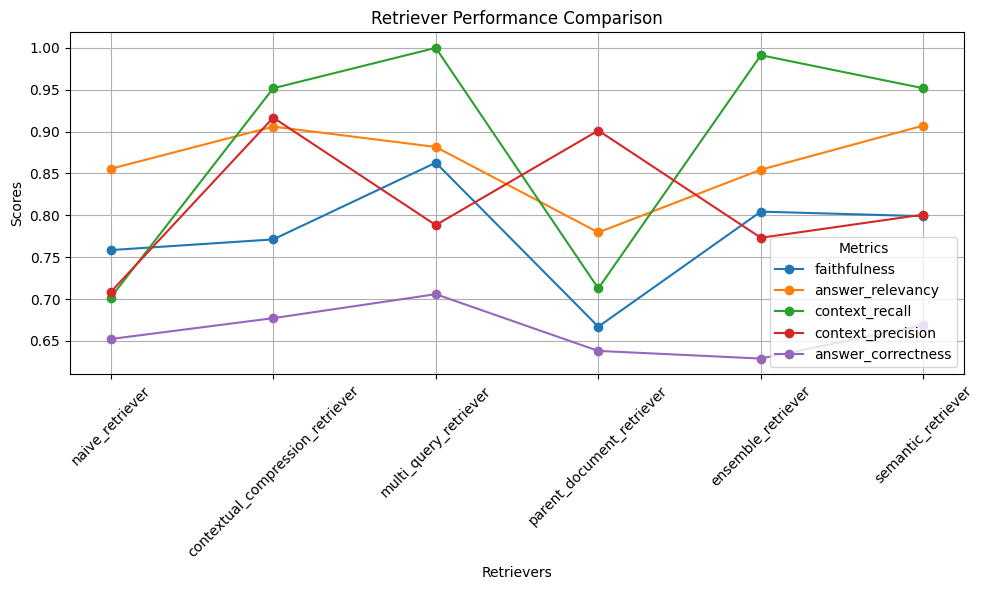

                          Retriever  faithfulness  answer_relevancy  \
0                   naive_retriever      0.758517          0.855564   
1  contextual_compression_retriever      0.771279          0.905936   
2             multi_query_retriever      0.862907          0.881699   
3         parent_document_retriever      0.667052          0.779600   
4                ensemble_retriever      0.804462          0.854553   
5                semantic_retriever      0.798990          0.907218   

   context_recall  context_precision  answer_correctness  
0        0.701754           0.708333            0.652326  
1        0.951754           0.916667            0.677241  
2        1.000000           0.788358            0.705882  
3        0.712719           0.901316            0.638134  
4        0.991228           0.773232            0.628974  
5        0.951754           0.800940            0.669000  


In [97]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the results into a DataFrame
df = pd.DataFrame(accumlated_evaluation_results).T
df.index.name = "Retriever"
df.reset_index(inplace=True)

# Plotting each metric for comparison
plt.figure(figsize=(10, 6))
metrics = ["faithfulness", "answer_relevancy", "context_recall", "context_precision", "answer_correctness"]

for metric in metrics:
    plt.plot(df["Retriever"], df[metric], marker='o', label=metric)

# Customize the plot
plt.title("Retriever Performance Comparison")
plt.xlabel("Retrievers")
plt.ylabel("Scores")
plt.xticks(rotation=45)
plt.legend(title="Metrics", loc="best")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Display the DataFrame as a table
print(df)

# Optional: Save the table to a CSV file if needed
df.to_csv("retriever_performance_results.csv", index=False)


### Observations

The **Multi Query Retriever** performs the best overall, achieving a high **context recall**, along with high faithfulness and answer relevancy, making it ideal for recall-heavy use cases. Its **context precision** is moderate, but it excels in retrieving relevant documents. 

The **Contextual Compression Retriever** is the second-best performer, with **high context recall, precision**, and strong answer relevancy, making it reliable for both accuracy and relevance.

The **Semantic Retriever** ranks well due to its high **answer relevancy** and **faithfulness**, but it slightly lags behind the top two in **answer correctness** and **context precision**.

In contrast, the **Parent Document Retriever** shows relatively weaker performance across most metrics, making it the least effective in this comparison. 

Final Observation: **Multi Query Retriever** performs the best overall, excelling in context recall and answer relevancy.